In [265]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [360]:
#generate data

x_a = np.linspace(-4,4, 25)
y_a = np.linspace(-4,4, 25)
theta_a = np.linspace(0,2*np.pi, 15)

x_d = np.linspace(-4,4, 1)
y_d = np.linspace(-4,4, 1)
theta_d = np.linspace(0,2*np.pi, 1)

xx_a, yy_a, tt_a, xx_d, yy_d, tt_d = np.meshgrid(x_a, y_a, theta_a, x_d, y_d, theta_d)
grid = np.vstack([xx_a.ravel(), yy_a.ravel(), tt_a.ravel(), xx_d.ravel(), yy_d.ravel(), tt_d.ravel()]).T



In [361]:
X = []
env = TwoPlayerDubinsCarEnv()
for g in grid:
    state = env.set(*g)
    print(state)
    X.append(state.copy())


{'attacker': array([-4., -4.,  0.], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32), 'defender': array([-4., -4.,  0.], dtype=float32)}
{'attacker': array([-4.   

In [362]:
X[:5]

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)}]

In [363]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(20000):
#     for player in env.players:
#         state = env.reset()
#         action = env.action_space[player].sample() 
#         X.append(np.hstack([state['attacker'], state['defender']]))
#         r = env.sample(state, action, player,0.5)
#         y.append(r)

# X = np.array(X)
# y = np.array(y)

# print(X[:5])
# print(y[:5])


In [364]:
X[2000]

{'attacker': array([-1.3333334, -2.3333333,  2.2439947], dtype=float32),
 'defender': array([-4., -4.,  0.], dtype=float32)}

In [365]:
X

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float

In [366]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])
    print(arrow_dx)

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


[0.25       0.22524221 0.15587245 ... 0.1558724  0.22524221 0.25      ]


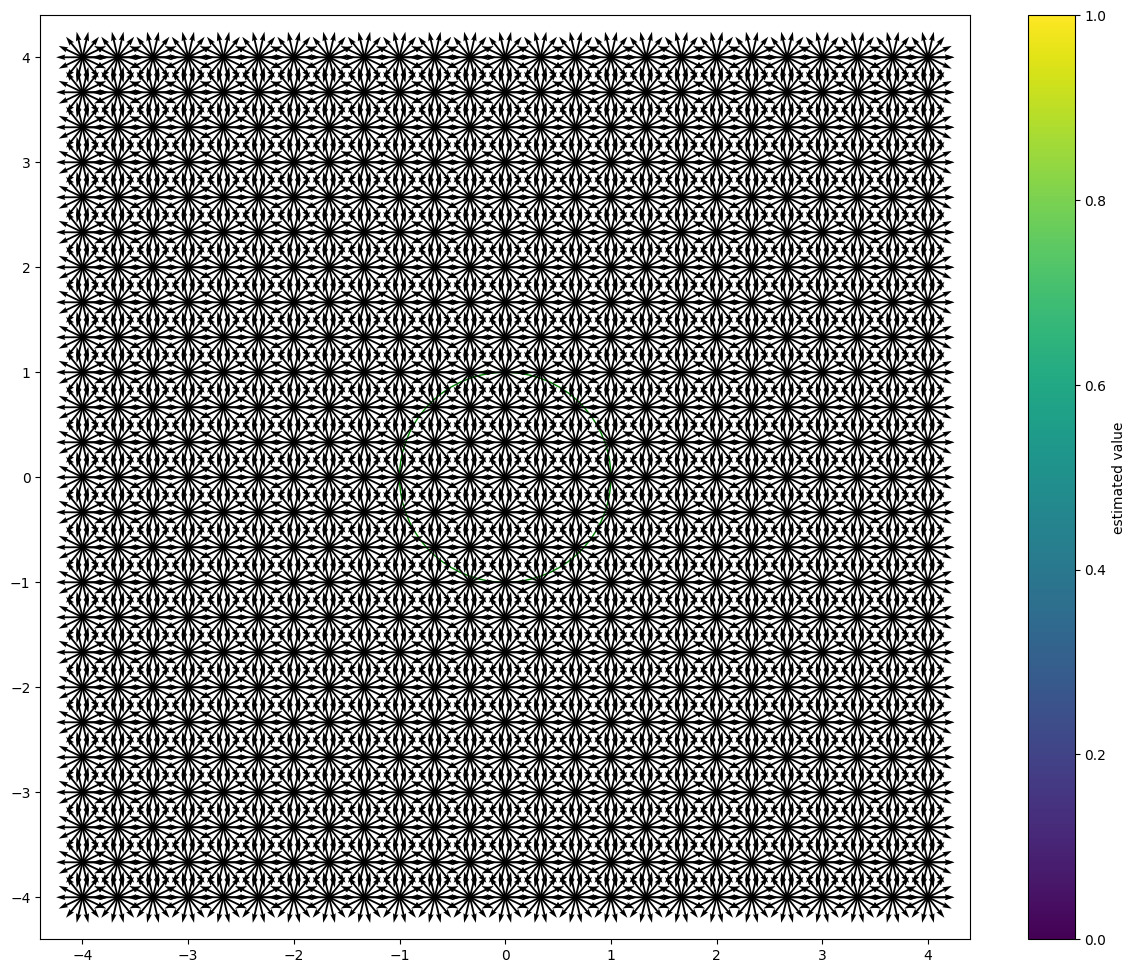

In [367]:
X_attacker = np.array([x['attacker'] for x in X])
plot_surface(X_attacker, env, None, [], [])

In [368]:
X

[{'attacker': array([-4., -4.,  0.], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.        , -4.        ,  0.44879895], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  0.8975979], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.3463968], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  1.7951958], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.2439947], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  2.6927936], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float32)},
 {'attacker': array([-4.       , -4.       ,  3.1415927], dtype=float32),
  'defender': array([-4., -4.,  0.], dtype=float

In [369]:
def encode(X):
    X = np.array(list(map(lambda row: (row['attacker'][0], row['attacker'][1], np.cos(row['attacker'][2]), np.sin(row['attacker'][2]), row['defender'][0], row['defender'][1], np.cos(row['defender'][2]), np.sin(row['defender'][2])), X)))

    return X

X = encode(X)
X


array([[-4.        , -4.        ,  1.        , ..., -4.        ,
         1.        ,  0.        ],
       [-4.        , -4.        ,  0.90096885, ..., -4.        ,
         1.        ,  0.        ],
       [-4.        , -4.        ,  0.6234898 , ..., -4.        ,
         1.        ,  0.        ],
       ...,
       [ 4.        ,  4.        ,  0.6234896 , ..., -4.        ,
         1.        ,  0.        ],
       [ 4.        ,  4.        ,  0.90096885, ..., -4.        ,
         1.        ,  0.        ],
       [ 4.        ,  4.        ,  1.        , ..., -4.        ,
         1.        ,  0.        ]], dtype=float32)

In [370]:
print(len(X))
print(len(y))

9375


NameError: name 'y' is not defined

In [371]:
# %%capture
# #generate data
# env = TwoPlayerDubinsCarEnv()

# state = env.reset()
# X = []
# y = []
# for i in range(50000):
#     for player in env.players:
#         state = env.reset()
#         X.append(np.hstack([state['attacker'], state['defender']]))


# X = np.array(X)



In [373]:
len(X)

9375

In [393]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(7):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


epoch 0 average loss 0.07269528 epoch delta inf
epoch 1 average loss 0.06461105 epoch delta 0.00808423
epoch 2 average loss 0.06382586 epoch delta 0.0007851869
epoch 3 average loss 0.062318105 epoch delta 0.0015077554
epoch 4 average loss 0.06169104 epoch delta 0.00062706694
epoch 5 average loss 0.060863968 epoch delta 0.0008270703
epoch 6 average loss 0.05991989 epoch delta 0.00094407797


In [25]:
# env = TwoPlayerDubinsCarEnv()
# state = env.reset()
# done = False
# max_iter = 50
# counter = 0
# print(env.state)
# while (not done) and (counter < max_iter):
#     counter+=1
#     possible_actions = []
#     for d_action in range(env.action_space['defender'].n):
#         state_ , reward, done, info = env.step(state, d_action, 'defender')
#         defender_actions = []
#         for a_action in range(env.action_space['attacker'].n):
#             next_state, reward, _, _ = env.step(state_, a_action, 'attacker')
#             #input = np.hstack([next_state['attacker'], next_state['defender']])
#             nn_input = env.state_for_nn(next_state)
#             estimate  = forward(X=nn_input, params=params)
#             print('estimate', estimate, 'actual', reward)
#             possible_actions.append([d_action, a_action, estimate[0]])
#         pa = np.array(possible_actions)
#     cand_attack_actions = np.argmax(pa.T,axis=0)
#     best_defender_action =  np.argmin(np.max(pa.T,axis=0))
#     best_attacker_action = cand_attack_actions[best_defender_action]
#     print(counter)
#     print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
#     print(env.state)

#     state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
#     #state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

#     env.render()
    
# env.make_gif()

{'attacker': array([-1.5498685 ,  2.4511783 ,  0.81426126], dtype=float32), 'defender': array([-0.8775566, -3.9365213,  4.8966017], dtype=float32)}
estimate [-0.13975853] actual 0
estimate [-0.14040552] actual 0
estimate [-0.18875167] actual 0
estimate [-0.14247812] actual 0
estimate [-0.14295587] actual 0
estimate [-0.1985466] actual 0
estimate [-0.04649051] actual 0
estimate [-0.04760687] actual 0
estimate [-0.13744986] actual 0
1
best defender action 0 best attacker action 0
{'attacker': array([-1.1621563 ,  2.4658332 ,  0.81426114], dtype=float32), 'defender': array([-0.9497542, -4.0438232,  4.8966017], dtype=float32)}
estimate [-0.11226199] actual 0
estimate [-0.11203356] actual 0
estimate [-0.15638223] actual 0
estimate [-0.112444] actual 0
estimate [-0.11156781] actual 0
estimate [-0.15796088] actual 0
estimate [0.00603581] actual 0
estimate [0.00960484] actual 0
estimate [-0.04360221] actual 0
2
best defender action 0 best attacker action 0
{'attacker': array([-0.9375614,  2.10

In [400]:
env = TwoPlayerDubinsCarEnv()
state = env.reset()
done = False
max_iter = 100
counter = 0
print(env.state)

while (not done) and (counter < max_iter):
    counter += 1
    pa = []
    for d_action in range(env.action_space['defender'].n):
        possible_actions = []  # Initialize possible_actions inside the d_action loop
        state_, reward, done, defender_info = env.step(state, d_action, 'defender')
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, done, info_attacker = env.step(state_, a_action, 'attacker')

            if info_attacker['player'] == 'attacker' and not info_attacker['is_legal']:
                possible_actions.append([d_action, a_action, -np.inf])
                print('illegal move')
                # If the attacker's move is illegal, skip it
            elif defender_info['status'] == 'eaten':
                done = True

            else:
                nn_input = env.state_for_nn(next_state)
                estimate = forward(X=nn_input, params=params)
                possible_actions.append([d_action, a_action, estimate[0]])
        pa.append(possible_actions)

    pa = np.array(pa)[:, :, 2].T
    if np.all(pa == -np.inf):
        print('all illegal moves')
        break


    cand_attack_actions = np.argmax(pa, axis=0)
    best_defender_action = np.argmin(np.max(pa, axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)
    print('best defender action', best_defender_action, 'best attacker action', best_attacker_action)
    print(env.state)

    state, reward, done, _ = env.step(action=best_defender_action, player='defender', update_env=True)
    state, reward, done, _ = env.step(action=best_attacker_action, player='attacker', update_env=True)

    env.render()
    
env.make_gif()


{'attacker': array([2.8796122, 2.9001565, 0.4504146], dtype=float32), 'defender': array([-1.7332196, -2.5081868,  3.738113 ], dtype=float32)}
1
best defender action 2 best attacker action 0
{'attacker': array([2.8796122, 2.9001565, 0.4504146], dtype=float32), 'defender': array([-1.7332196, -2.5081868,  3.738113 ], dtype=float32)}
2
best defender action 1 best attacker action 0
{'attacker': array([3.073367 , 2.7421722, 5.599136 ], dtype=float32), 'defender': array([-1.6933438, -2.754986 ,  4.8725767], dtype=float32)}
3
best defender action 1 best attacker action 1
{'attacker': array([3.0120692, 2.4998035, 4.464672 ], dtype=float32), 'defender': array([-1.6534679, -3.0017853,  4.8725767], dtype=float32)}
4
best defender action 1 best attacker action 1
{'attacker': array([2.9507713, 2.2574348, 4.464672 ], dtype=float32), 'defender': array([-1.613592 , -3.2485845,  4.8725767], dtype=float32)}
5
best defender action 1 best attacker action 1
{'attacker': array([2.8894734, 2.0150661, 4.464672

In [395]:
y_train = [forward(X=x, params=params) for x in X]


[0.25       0.22524221 0.15587245 ... 0.1558724  0.22524221 0.25      ]


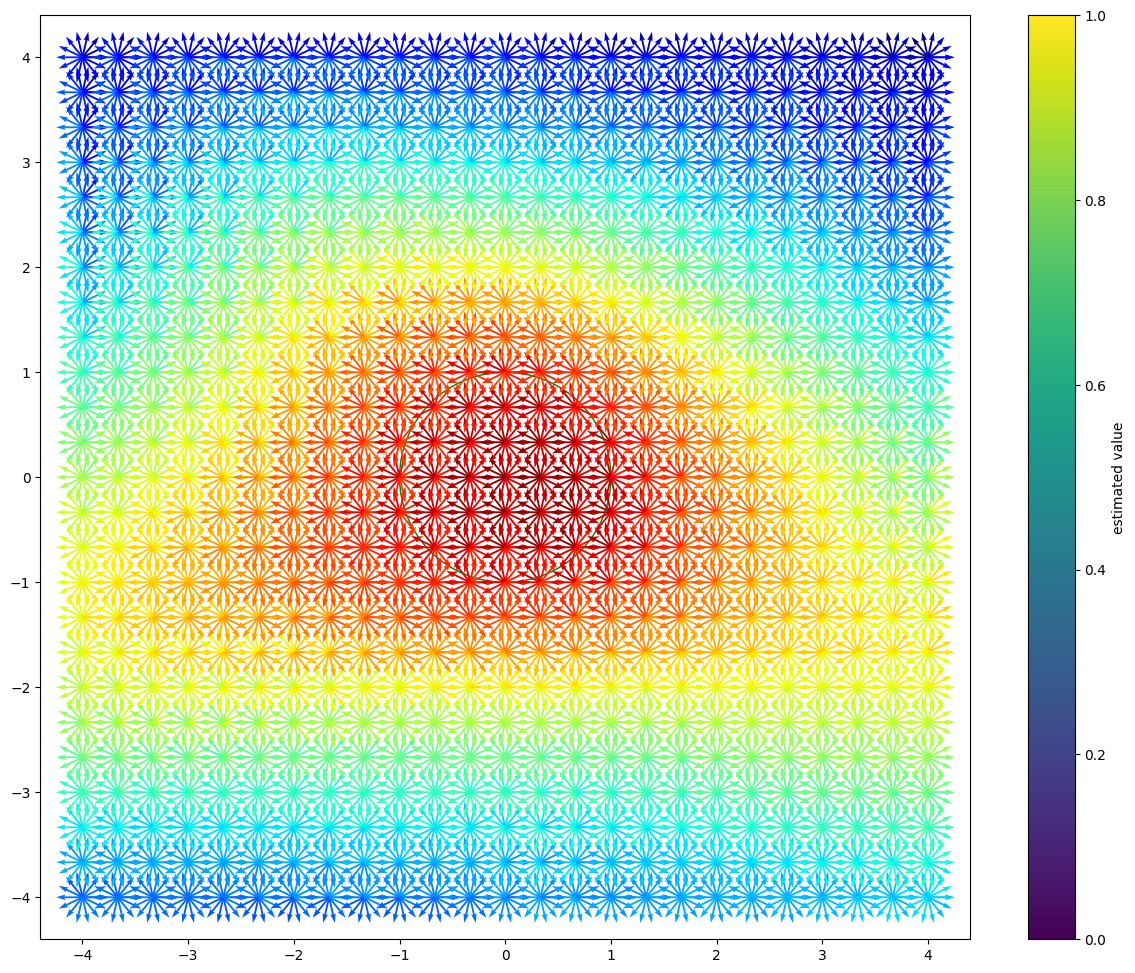

In [396]:
plot_surface(X_attacker, env, 'experiment2.png', y_train)

In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa[best_defender_move][best_attacker_move]

In [ ]:
possible_actions